In [5]:
from yahoo_fin.stock_info import tickers_dow, tickers_sp500, tickers_nasdaq, tickers_other

In [14]:
sample_list = [1, 2, 3]
file_name = "sample.pkl"

In [17]:
import pickle

open_file = open(file_name, "wb")
pickle.dump(sample_list, open_file)
open_file.close()

In [18]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [19]:
print(loaded_list)

[1, 2, 3]


In [20]:
loaded_list

[1, 2, 3]

In [23]:
for n in range(4):
    print(n)

0
1
2
3


                 AAPL       AMGN        AXP         BA        CAT        CRM  \
Date                                                                           
2011-01-06        NaN        NaN        NaN        NaN        NaN        NaN   
2011-01-07  10.355506  45.424686  38.376865  54.989922  69.564758  35.555000   
2011-01-10  10.550530  44.994202  38.463371  54.760052  69.312408  35.660000   
2011-01-11  10.525573  44.794903  38.965153  54.657021  69.728004  35.279999   
2011-01-12  10.611223  45.321037  38.930557  55.600216  69.386627  35.410000   

                 CSCO        CVX        DIS  DOW          GS         HD  \
Date                                                                      
2011-01-06        NaN        NaN        NaN  NaN         NaN        NaN   
2011-01-07  15.682029  61.661137  34.737968  NaN  146.464157  27.333136   
2011-01-10  15.547424  61.133717  34.782001  NaN  145.666183  27.341080   
2011-01-11  15.614729  62.093887  34.693939  NaN  145.322906  27

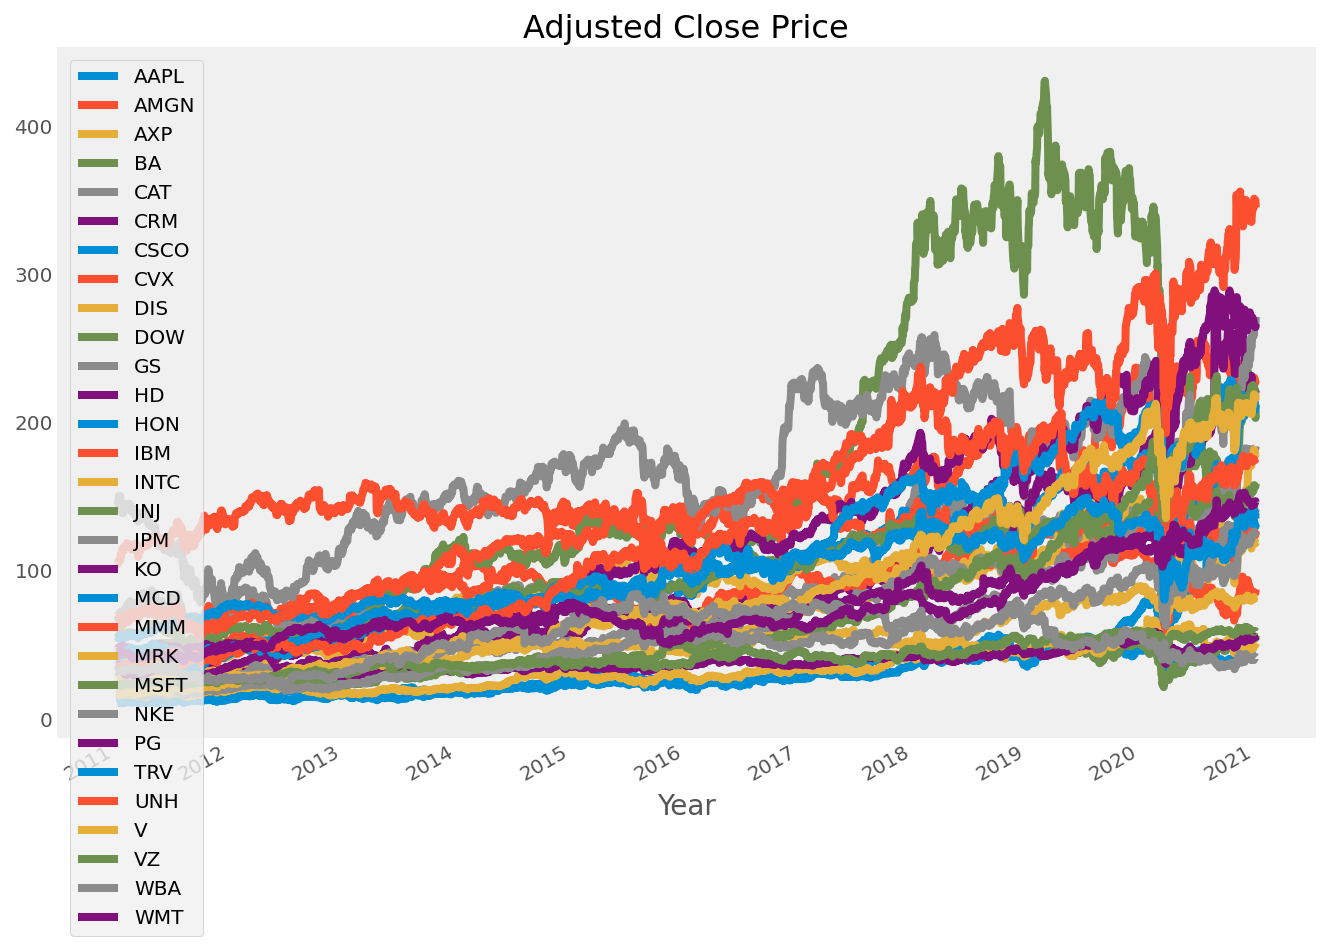

In [64]:
start = datetime(2020, 6, 1)
end = datetime.now()
start_date = start
end_date = end

plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

p = "/home/gordon/work/Where-To-Put-Your-Money-In-Hard-Times/data/"
path = p + 'raw/dow_10y_1d.pkl'
PT_data = pd.read_pickle(path)
PT = pd.DataFrame(PT_data)

tickers = list(PT.columns)

# Plot all the close prices
PT.plot(figsize=(10,7))
plt.legend()
plt.title("Adjusted Close Price", fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
print(PT.head())
plt.show();

In [124]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios), dtype=object)
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights = np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(
            weights, mean_returns, cov_matrix)
        # func(results[0],i) = portfolio_std_dev
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = ((portfolio_return - risk_free_rate) / portfolio_std_dev)
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    rr = np.array(results[2])
    max_sharpe_idx = rr.argmax()
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=PT.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=PT.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [130]:
# display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [131]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,],
                          args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=PT.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=PT.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.26
Annualised Volatility: 0.19


             AAPL  AMGN  AXP   BA  CAT  CRM  CSCO  CVX  DIS  DOW   GS     HD  \
allocation  18.96   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  19.34   

            HON  IBM  INTC  JNJ  JPM   KO  MCD  MMM  MRK  MSFT    NKE   PG  \
allocation  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.14  11.04  0.0   

            TRV    UNH      V   VZ  WBA   WMT  
allocation  0.0  17.85  23.25  0.0  0.0  6.42  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.13


            AAPL  AMGN  AXP   BA  CAT  CRM  CSCO  CVX  DIS  DOW   GS   HD  \
allocation  0.92   0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0   

            HON  IBM  INTC    JNJ  JPM     KO    MCD  MMM   MRK  MSFT  NKE  \

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
# display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [ ]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'],
                                               mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=PT.columns,
                                         columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation
    

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=PT.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
 
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(PT.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),
               ", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(PT.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), 
                    xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500,
               label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',
               color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.',
            color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

In [ ]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)